# Data preparation

## Methodology

For each postal code:

1. Classify buildings into types (manual)
1. Calculate total area for all objects
1. Group buildings by type to get for each type (residential, industrial,...etc.)
    1. Rectangularity (area of polygon / area of minimum bounding box of polygon)
    1. Total area

# Initialization

In [22]:
import pandas as pd
import numpy as np
import sys

from datetime import datetime
timestamp = datetime.now().strftime("%d%m%y")

## Load custom modules

In [23]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Read 

In [ ]:
plz_csv = '../data/01_raw/plz_einwohner.csv'

In [ ]:
# Postal code list with population data (2011)
plz_de = pd.read_csv(plz_csv,
                    dtype={'plz': str, 'einwhoner': int}) # specify column types

In [ ]:
# Get all existing PLZ done
import os
name_list = os.listdir('../data/01_raw/buildings_plz/')

done_plz = [x.split('.')[0].split('_')[1] for x in name_list if 'buildings' in x]
print(f'Completed crawling for {len(done_plz)} PLZs')

In [ ]:
plz_de = plz_de[plz_de.plz.isin(done_plz) == False].reset_index(drop = True)

1. Manual classify buildings into 7 categories: residential, public, commercial, accessory:storage, accessory:supply, industrial and other.
1. Calculate surface area of all the buildings (floor area * building levels)
1. Extract "residential" & "other" type to a separate dataset for ML modeling (guessing building types?)

In [ ]:
plz = done_plz[10]

In [ ]:
plz_path = f'../data/01_raw/buildings_plz/buildings_{plz}.csv'
plz_path

In [ ]:
df = pd.read_csv(plz_path,
                 dtype={'tags.addr:suburb': 'object',
                        'tags.building:levels': 'object',
                        'tags.source' :str,
                        'tags.addr:postcode':str},
                converters={"nodes": lambda x: x.strip("[]").split(", ")}) # read column as list

# remove empty elements (no lat/lon)
df = df[df['center.lat'].isna()==False].reset_index(drop = True)
# replace NaN in building_levels
df['tags.building:levels'] = df['tags.building:levels'].fillna(1)

# Classify to building types
df['building_types'] = df['tags.building'].apply(lambda x: dp.manual_classify_building(x))

In [ ]:
idx = 0
# df['total_area'] = None

In [ ]:
# Calculate total area of the building

while idx < len(df):
    df['total_area'].iloc[idx] = dp.get_total_area(df['nodes'].iloc[idx],
                                                   df['tags.building:levels'].iloc[idx])
    if idx % 100 == 0: print(f'{idx}/{len(df)}')
    idx = idx + 1

In [ ]:
df[df.total_area ==0 ].shape

In [ ]:
gp.plot_buildings_plz(df, plz)

## Test on PBF reader

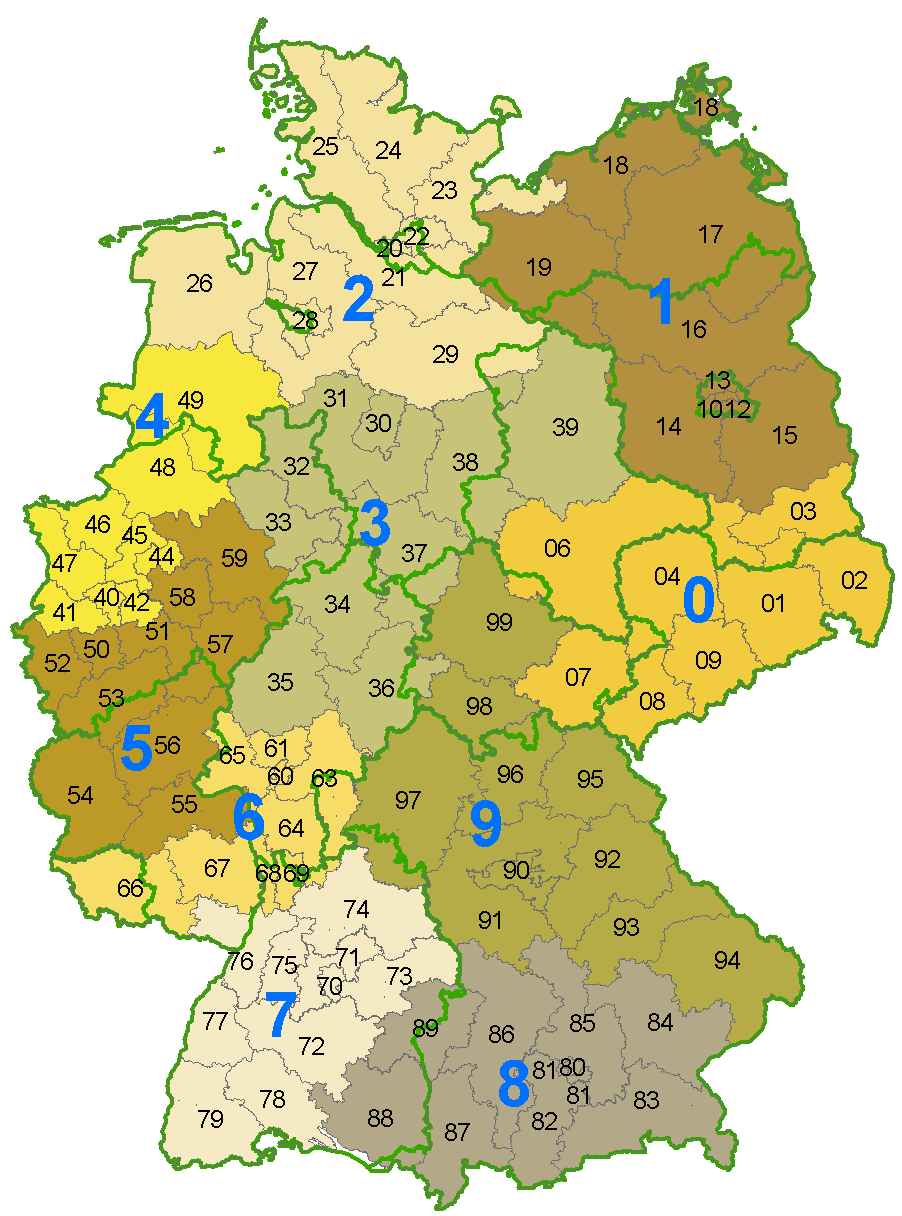

In [11]:
# input_pbf = '../data/01_raw/geofabrik/germany-latest.osm.pbf'

input_pbf = '../data/01_raw/geofabrik/oberbayern-latest.osm.pbf'

In [4]:
#2
from pyrosm import OSM

In [12]:
# Initialize the OSM parser object
osm = OSM(input_pbf)

In [13]:
%%time
buildings = osm.get_buildings()
# # buildings.plot()

C:\anaconda\envs\geopandas_env\lib\site-packages\pyrosm\buildings.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=None


2020-11-21 23:44:43,167 - shapely.geos - INFO - Self-intersection at or near point 11.3841386 49.0001338
2020-11-21 23:44:43,272 - shapely.geos - INFO - Self-intersection at or near point 11.296469099999999 48.131368999999999


In [19]:
len(buildings)

1367735

In [24]:
buildings[buildings.id == 17740278]

,addr:city,addr:country,addr:full,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,opening_hours,operator,phone,ref,url,website,building,amenity,building:flats,building:levels,building:material,building:min_level,building:fireproof,building:use,craft,height,internet_access,landuse,levels,office,shop,source,start_date,wikipedia,id,timestamp,version,tags,geometry,osm_type,changeset
436,None,None,None,7,None,None,None,Höglweg,None,None,None,None,None,None,None,None,sports_centre,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,17740278,1552395007,10,"{""sport"":""squash"",""leisure"":""sports_centre""}","POLYGON ((11.72859 48.11548, 11.72855 48.11540, 11.72839 48.11504, 11.72888 48.11494, 11.72890 48.11494, 11.72909 48.11537, 11.72872 48.11545, 11.72859 48.11548))",way,NaN


In [18]:
# Print info
print(f"Existing columns:\n", buildings.columns)
print(f"\nAdditional attributes in the 'tags': \n", buildings.tags.unique())

Existing columns:
 Index(['addr:city', 'addr:country', 'addr:full', 'addr:housenumber',
       'addr:housename', 'addr:postcode', 'addr:place', 'addr:street', 'email',
       'name', 'opening_hours', 'operator', 'phone', 'ref', 'url', 'website',
       'building', 'amenity', 'building:flats', 'building:levels',
       'building:material', 'building:min_level', 'building:fireproof',
       'building:use', 'craft', 'height', 'internet_access', 'landuse',
       'levels', 'office', 'shop', 'source', 'start_date', 'wikipedia', 'id',
       'timestamp', 'version', 'tags', 'geometry', 'osm_type', 'changeset'],
      dtype='object')

Additional attributes in the 'tags': 
 ['{"sport":"equestrian","leisure":"horse_riding","description":"riding_hall"}'
 '{"created_by":"JOSM"}' None ...
 '{"type":"multipolygon","roof:levels":"1","building:levels:underground":"1"}'
 '{"addr:suburb":"Erlbach","type":"multipolygon"}'
 '{"government":"patent_office","name:en":"European Patent Office - Isar building",

<AxesSubplot:>

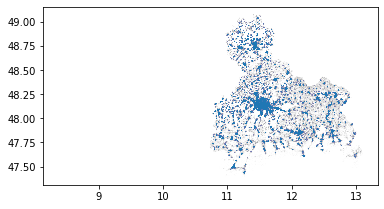

In [16]:
buildings.plot()